# <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> EE 046202 - Technion - Unsupervised Learning & Data Analysis

* Formerly 046193 

#### Tal Daniel

## Tutorial 12 - Spectral Clustering

<img src="./assets/tut_xxl_spectral_illustration.png" style="height:250px">
* Source: <a href="http://www.cs.cornell.edu/courses/cs4786/2017fa/lectures/lec14.pdf"> Cornell's CS 4786/5786: Machine Learning for Data Science</a>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda

* Motivation and Introduction
* Graph Clustering Formulation and Notations
    * Graph Laplacian
* Graph Clustering Algorithm
* Example
* GraphCut Point-of-View
    

In [1]:
# imports for the tutorial
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_circles, make_moons
from sklearn.cluster import SpectralClustering, KMeans

## <img src="https://img.icons8.com/dusk/64/000000/confetti.png" style="height:50px;display:inline"> Motivation - Why Use Graphs for Clustering?
* As you have seen in class, the *k-means* can sometimes fail due to utilization of an **inappropriate dissimilarity measure**.
    * A good idea would be to map the points to another manifold or use different coordinates (e.g. polar) and then run k-means.
        * We did something similar when we talked about *non-linear* **dimensionality reduction**!
    * **The problem**: while the *local* neighborhood structure is Euclidean, this is not the case for the **global structure**.

* In **spectral clustering** we use the idea of working with another form of the data, that is, we will map the clustering problem to a graph.
    * This will enable us to use tools from Graph Theory to derive new clustering algorithms.
    * In other words, the idea is to identify communities of nodes in a graph based on the edges connecting them. The method is flexible and allows us to cluster non-graph data as well.
* Spectral clustering uses information from the eigenvalues (spectrum) of special matrices built from the graph or the data set.

* It can be used in many other fields, like Computer Vision: spectral partitioning for automatic separation of foreground from the background on another image: <img src='./assets/tut_xxl_spectral_partition.png' style="height:200px">

<img src="./assets/tut_xxl_spectral_circles.gif" style="height:300px">

* Image and animation by <a href="https://sandipanweb.wordpress.com/2016/07/30/comparing-spectral-clustering-with-normalized-graph-laplacian-with-kmeans-clustering/">SANDIPANWEB</a>

## <img src="https://img.icons8.com/bubbles/50/000000/form.png" style="height:50px;display:inline"> Graph Clustering Formulation and Notation

* Consider $n$ data points, $\mathcal{D}=\{ x_i\}_{i=1}^n$, and a **similarity measure** $w(x_i, x_j) = w_{ij} \geq 0$
* **Goal**: divide the data into $k$ groups or clusters such that points in the same group are similar and points in differenet groups are dissimilar to each other.
* Let $G=(V,E)$ be an *undirected* graph with vertex set $V=\{v_1, ..., v_n\}$
    * The vertex $v_i$ in the graph represents the data point $x_i$

* The weighted adjacency matrix, $W \in \mathbb{R}^{n \times n}$, with $w_{ij} = w(x_i, x_j)$. If $w_{ij} = 0$ we say that the vertices $v_i$ and $v_j$ are disconnected.
    * Two vertices $v_i$ and $v_j$ are connected by an **edge** with weight $w_{ij}$ (more generally, one can set the weight to 0, if its value is below some threshold $\epsilon$).
    <img src="./assets/tut_xxl_weight.png" style="height:100px">

* The **degree** of a vertex $v_i \in V$ is defined as $d_i = \sum_{j=1}^n w_{ji}$. $D \in \mathbb{R}^{n \times n}$ is the *diagonal* matrix with $d_1, ..., d_n$ on the diagonal.
    * <img src="./assets/tut_xxl_degree.png" style="height:100px">

* Given a subset of vertices $A \subset V$, we denote its complement $V / A$ by $\overline{A}$
    * <img src="./assets/tut_xxl_subset.png" style="height:100px">

* Connected Componenet: A is a connected component of the graph, that is, comprised of connected vertices (there is a path from each vertex to any other vertex in the subset) and there are no connections between $A$ and $\overline{A}$. 
* The non-empty subsets $A_1, ..., A_k$ form a **partition** of the graph if $\forall i,j: A_i \cap A_j = \emptyset$ and $A_1 \cup ... \cup A_k = V$.
* Let $A$ be a subset of vertices. We define the indicator vector $\mathbb{1}_A \in \mathbb{R}^n$ as the vector $$ (\mathbb{1}_A)_i \begin{cases} 1, \text{ if } v_i \in A \\ 0, \text{ otherwise} \end{cases} $$

#### Similarity Graph
The goal is to build a graph based on what we described. There are 3 types of similarity graph that we can build:

* *$\epsilon$-neighborhood graph* - we connect all points whose pairwise distances are smaller than $\epsilon$. As the distances between all connected points are roughly of the same scale, weighting the edges would not incorporate more information about the data to the graph. Hence, the $\epsilon$-neighborhood graph is usually considered as an unweighted graph.

* KNN graph - Here we use $K$-Nearest Neighbors to connect vertex $v_i$ with vertex $v_j$ if $v_j$ is among the $K$-nearest neighbors of $v_i$.
    * A problem with that is that if the nearest neighbors are not symmetric, i.e. if there is a vertex $v_i$ which has $v_j$ as a nearest neighbor, it is not necessary that $v_i$ is a nearest neighbor of $v_j$. Thus, we end up getting a directed graph which is a problem as we do not know what similarity between 2 points means in that case. There are two ways of making this graph undirected:
        * Ignore the directions of the edges, i.e. we connect $v_i$ and $v_j$ with an undirected edge if $v_i$ is among the $K$-nearest neighbors of $v_j$ or if $v_j$ is among the $K$-nearest neighbors of $v_i$ . The resulting graph is what is usually called the $K$-nearest neighbor graph.
        * Connect vertices $v_i$ and $v_j$ if both $v_i$ is among the $K$-nearest neighbors of $v_j$ and $v_j$ is among the $K$-nearest neighbors of $v_i$ . The resulting graph is called the *mutual* $K$-nearest neighbor graph.

* Fully connected graph - we connect all points with each other, and we weight all edges by similarity $s_{ij}$. This graph should model the local neighborhood relationships, thus similarity functions such as Gaussian similarity function are used.

#### Graph Laplacians
We define 2 types of graph Laplacians:
1. The **unnormalized** graph Laplacian matrix: $$ L=D-W $$
2. The **normalized** graph Laplacian matrix:
    * **Symmetric** version: $$ L_{sym} = D^{-\frac{1}{2}}LD^{-\frac{1}{2}} $$
    * **Random Walk** version: $$ L_{rw} = D^{-1}L = I - D^{-1}W $$

#### <img src="https://img.icons8.com/dusk/64/000000/task.png" style="height:30px;display:inline"> Exercise - The Unnormalized Graph Laplacian
Consider the unnormalized graph Laplacian matrix as defined above ($ L=D-W $).

Prove the following properties of the Laplacian:
1. For every vector $f \in \mathbb{R}^n$ we have, $$ f^TLf = \frac{1}{2}\sum_{i,j=1}^n w_{ij}(f_i -f_j)^2 $$
2. $L$ is *symmetric* and **positive semi-definite** (PSD).
3. The smallest eigenvalue of $L$ is 0, and the corresponding eigenvector is the constant one vector (a vector of ones).
4. $L$ has $n$ non-negative, real-valued eigenvalues.
5. Let $G$ be an undirected graph with non-negative weights. Then the multiplicity $k$ of the eigenvalue 0 of $L$ equals the number of connected components $A_1, A_2, ..., A_k$ in the graph. The eigenspace of eigenvalue 0 is spanned by the indicator vectors $1_{A_1}, ...., 1_{A_k}$.

#### <img src="https://img.icons8.com/dusk/64/000000/idea.png" style="height:30px;display:inline"> Solution
#### Section 1

* Prove: for every vector $f \in \mathbb{R}^n$ we have, $$ f^TLf = \frac{1}{2}\sum_{i,j=1}^n w_{ij}(f_i -f_j)^2 $$

By definition of $d_i$ ($d_i = \sum_j w_{ij}$) and recall that $D$ (matrix of degrees) is a diagonal matrix: $$ f^TLf = f^TDf - f^TWf =  $$ $$ \sum_{i=1}^n d_i f_i^2 - \sum_{i=1}^n \sum_{j=1}^nf_if_jw_{ij} = \frac{1}{2}\big(2\sum_{i=1}^n d_if_i^2 -2\sum_{i=1}^n\sum_{j=1}^nf_if_jw_{ij} \big) = $$ <br> 

Changing index from $i$ to $j$: $$ \frac{1}{2}\big(\sum_{i=1}^n d_if_i^2 -2\sum_{i=1}^n\sum_{j=1}^nf_if_jw_{ij} + \sum_{j=1}^n d_jf_j^2  \big) = $$ <br> Expanding $d_i, d_j$: $$ \frac{1}{2}\big(\sum_{i=1}^n \sum_{j=1}^n w_{ij} f_i^2 -2\sum_{i=1}^n\sum_{j=1}^nf_if_jw_{ij} + \sum_{j=1}^n\sum_{i=1}^n w_{ji}f_j^2  \big) =  $$ From the symmetry of $W$ ($w_{ij} = w_{ji}$): $$ \frac{1}{2}\sum_{i,j=1}^n w_{ij}(f_i -f_j)^2 $$

#### Section 2

* Prove: $L$ is *symmetric* and **positive semi-definite** (PSD).

The symmetry of $L$ follows directly from the symmetry of $W$ and $D$ ($W=W^T, D=D^T$). The positive semi-definiteness is a direct consequence of part 1, which shows that $f^TLf \geq 0$ for all $f \in \mathbb{R}^n$.

#### Section 3

* Prove: The smallest eigenvalue of $L$ is 0, and the corresponding eigenvector is the constant one vector (a vector of ones).

Suppose $u \in \mathbb{R}^n$ is an eigenvector of $L$ with eigenvalue 0, then: $$ L\cdot u = 0 \rightarrow (D- W) \cdot u =0 $$ $$ \rightarrow \begin{bmatrix} d_1 -w_{11} & -w_{21} & \dots & -w_{n1} \\ -w_{12} & d_2 -w_{22} & \dots & -w_{n2} \\ \vdots & \ddots & & \vdots \\ -w_{1n} & \dots & & d_n - w_{nn}  \end{bmatrix} \cdot \begin{bmatrix} u_1 \\ \vdots \\ u_n \end{bmatrix} = \begin{bmatrix} 0 \\ \vdots \\ 0 \end{bmatrix} $$ Let's see what we get for the first row: $$ (d_1 - w_{11})u_1 -w_{21}u_2 - \dots -w_{n1} u_n =0 \rightarrow d_1u_1 = u_1w_{11} + u_2w_{21} + \dots u_n w_{n1} $$ 

And in general, for $ \overline{u} = \overline{1}$: $$ d_i = \sum_{j=1}^nw_{ji} $$
We get that since $L$ is PSD, the smallest eigenvalue of $L$ is 0, and the corresponding eigenvector is the constant one vector (a vector of ones).

#### Section 4

* Prove: $L$ has $n$ non-negative, real-valued eigenvalues.

From part 3 we have seen that the 0 eigenvalue exists. Since $L$ is PSD we know that all eigenvalues are greater or equal to 0, which makes $L$ have only non-negative, real-valued eigenvalues.

#### Section 5

* Prove: Let $G$ be an undirected graph with non-negative weights. Then the multiplicity $k$ of the eigenvalue 0 of $L$ equals the number of connected components $A_1, A_2, ..., A_k$ in the graph. The eigenspace of eigenvalue 0 is spanned by the indicator vectors $1_{A_1}, ...., 1_{A_k}$.

You have seen this in lecture. We start with the case where a single connected component exists. Assume that $f$ is an eigenvector with eigenvalue 0. Then we know that: $$ 0 = f^TLf = \frac{1}{2}\sum_{i,j=1}^n w_{ij}(f_i -f_j)^2 $$
As the weights $w_{ij}$ are non-negative, this sum can only vanish if all the terms $ w_{ij}(f_i -f_j)^2 $ vanish. Thus, if two vertices are connected ($w_{ij} > 0$) then $f_i$ needs to equal $f_j$ needs to equal $f_i$. Since we are dealing with a *double-sum*, we can see that $f$ needs to be constant on the whole connected componnent.

Now, consider the case the case of $k$ connected components. Without loss of generality we assume that that the vertices are ordered according to the connected components they belong to. In this case, the adjacency matrix, $W$, has a block diagram form, and the same is true for the matrix $L$.

Note that each of the blocks $L_i$ is a proper graph Laplacian on its own, namely the Laplacian corresponding to the subgraph of the $i^{th}$ component. As it is the case for all block diagonal matrices, we know that the spectrum of $L$ is given by the union of the spectra of $L_i$ and the corresponding eigenvectors of $L$ are the eigenvectors of $L_i$, filled with 0 at the positions of the other blocks. The **spectrum** of the Laplacian: $$ 0=\lambda_1 \leq \lambda_2 \leq ... \lambda_n $$

As each $L_i$ is a graph Laplacian of a connected graph, we know that every $L_i$ has eigenvalue 0 with multiplicity 1, and the corresponding eigenvector is the constant one vector on the $i^{th}$ connected component. Thus, the matrix $L$ has as many eigencalues 0 as there are connected components, and the corresponding eigenvectors are the indicator vectors of the connected components.

## <img src="https://img.icons8.com/ios/100/000000/rubiks-cube.png" style="height:50px;display:inline"> Spectral Clustering Algorithm

<img src="./assets/tut_xxl_spectral_algorithm.png" style="height:300px">

We will follow an example by <a href="https://towardsdatascience.com/spectral-clustering-82d3cff3d3b7">Neerja Dosh</a>

### <img src="https://img.icons8.com/dusk/64/000000/1-circle-c.png" style="height:40px;display:inline"> Step 1 - Build Similarity Graph
Pick a type of similarity graph, as mentioned in the beginning. Let's consider the following graph with 4 nodes (i.e., 4 points in the data):
<img src="./assets/tut_xxl_step_1.png" style="height:150px">

### <img src="https://img.icons8.com/dusk/64/000000/2.png" style="height:40px;display:inline"> Step 2 - Project to Lower-Dimensional Space (Using Graph Laplacian)
The goal here is to transform the space so that when the 2 points are close, they are always in same cluster, and when they are far apart, they are in different clusters. We need to project the data into a low-dimensional space, or another manifold. For this, we compute the Graph Laplacian, $L$, which gives us a representation of a graph that is useful in finding interesting properties of a graph. Calculate $L = D-W$, for example:
<img src="./assets/tut_xxl_step_2.png" style="height:100px">

We calculate the Graph Laplacian $L$ in order to find eigenvalues and eigenvectors for it, and embed the data points into a low-dimensional space. As you recall: $$ L\lambda = \lambda v $$ Where $v$ is the eigenvector of $L$ corresponding to eigenvalue $\lambda$. For the first exercise, we know that: $$ 0 = \lambda_1 \leq \lambda_2 \leq ... \lambda_n $$
1. If $L$ has eigenvalue 0 with $k$ different eigenvectors, such that $0=\lambda_1=\lambda_2=...= \lambda_k$, then graph $G$ has $k$ connected components.
2. If $G$ is connected, i.e., $\lambda_1 =0, \lambda_2 >0$, then $\lambda_2$ is the *algebraic* conncetivity of $G$. Thus, the greater $\lambda_2$, the greater the connectivity.

* Dimensionality reduction: we take the first $k$ eigenvectors of $L$.

An example with numbers:
<img src="./assets/tut_xxl_step_2_1.png" style="height:200px">

### <img src="https://img.icons8.com/dusk/64/000000/3-circle--v1.png" style="height:40px;display:inline"> Step 3 - Clustering
Time to put the cherry on the cake! 
* We start with $k=2$, that is, we want to cluster our data in 2 partitions. For this, we use the eigenvector corresponding to the 2nd eigenvalue to assign values to each node. In the table above, calculating the eigenvalues and eigenvectors, we get that the second eigenvalue is $0.189$ and the corresponding eigenvector: $$ v_2 = [0.41, 0.44, 0.37, -0.4, -0.45, -0.37] $$

To get bipartite clustering (2 clusters), we first assign each element of $v_2$ to the nodes such that: $node_1: 0.41, node_2: 0.44, ..., node_6: -0.37$. We then split the nodes such that all nodes with value greater than 0 are in one cluster, and all the other nodes are in the other cluster. We can alternatively, run K-means with $k=2$ (which will yield the same result here). <img src="./assets/tut_xxl_step_3.png" style="height:250px">

* For a general $k$, we usually normalize the Laplacian (because the degrees may vary significantly which yields different Laplacians): $$ L_{norm} = D^{-\frac{1}{2}}LD^{-\frac{1}{2}}$$ <img src="./assets/tut_xxl_step_3_1.png" style="height:150px">
    * Compute the first $k$ eigenvectors of $L_{norm}$: $v_1, v_2, ..., v_k $
    * Stack the vectors *vertically* to form a matrix with the vectors as columns.
    * Represent every node by the corresponding **row** of this new matrix. These rows are now the *feature vectors* of the nodes.
    * Use **K-Means** clustering to cluster these points into $k$ clusters.

In [4]:
# example
# let's generate some data
def generate_plot_data():
    X_1, y_1 = make_circles(n_samples=1000, noise=.05, factor=.5, random_state=0)
    X_2, y_2 = make_moons(1000, noise=.07, random_state=0)
    # plot
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.scatter(X_1[:, 0], X_1[:, 1], color='b')
    ax1.set_title("Circles Dataset")

    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(X_2[:, 0], X_2[:, 1], color='b')
    ax2.set_title("Moons Dataset")
    return X_1, y_1, X_2, y_2

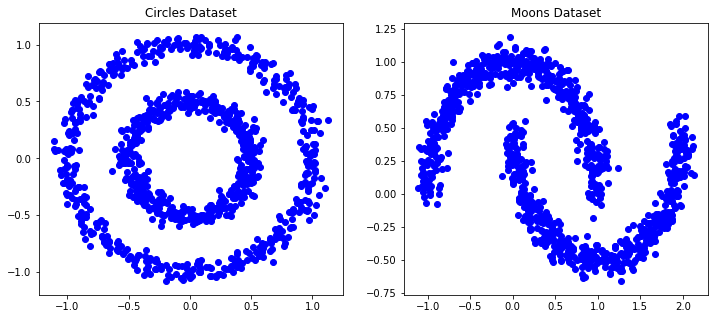

In [5]:
X_1, y_1, X_2, y_2 = generate_plot_data()

In [6]:
def plot_kmeans(X_1, X_2):
    km = KMeans(n_clusters=2)
    km_labels_1 = km.fit(X_1)
    km_labels_2 = km.fit(X_2)

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.scatter(X_1[:, 0], X_1[:, 1], c=km_labels_1.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')
    ax1.set_title("K-Means on the Circles Dataset")

    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(X_2[:, 0], X_2[:, 1], c=km_labels_2.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')
    ax2.set_title("K-Means on the Moons Dataset")

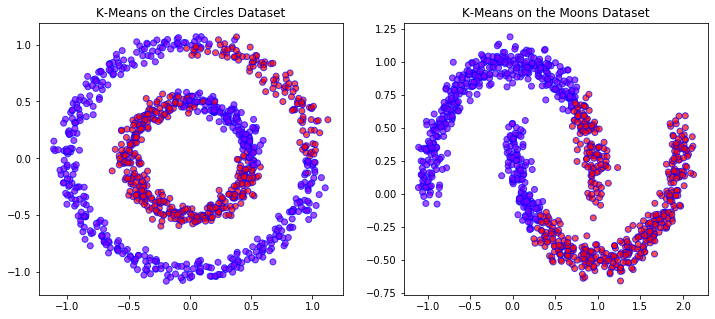

In [7]:
# let's see what K-Means outputs
plot_kmeans(X_1, X_2)

In [8]:
import warnings
warnings.filterwarnings("ignore", message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.", category=UserWarning)
def plot_spectral_clustering(X_1, X_2):
    sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
    sc_labels_1 = sc.fit(X_1)
    sc_labels_2 = sc.fit(X_2)

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.scatter(X_1[:, 0], X_1[:, 1], c=sc_labels_1.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')
    ax1.set_title("Spectral Clustering on the Circles Dataset")

    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(X_2[:, 0], X_2[:, 1], c=sc_labels_2.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')
    ax2.set_title("Spectral Clustering on the Moons Dataset")

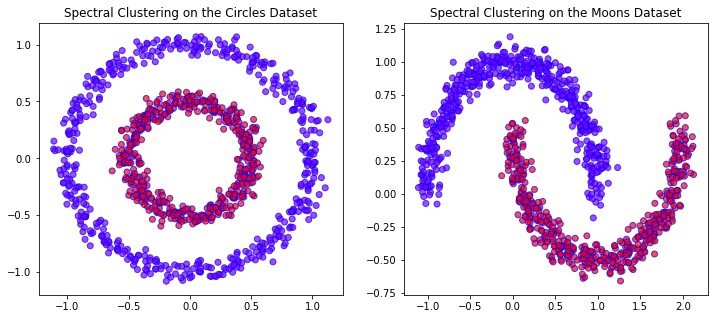

In [9]:
# let's see what Spectral Clustering outputs
plot_spectral_clustering(X_1, X_2)

## <img src="https://img.icons8.com/color/96/000000/graph-clique.png" style="height:50px;display:inline"> GraphCut Point-of-View
* We motivated spectral clustering by representing the data with a (similarity) graph.
* The goal: find a **partition** of the graph such that the edges between different groups (=partitions) have a *very low weight* (which means large dissimilarity between points in each group) and the edges **within** a group have *high weight* (which means points in the same cluster are similar to each other).
* Graph partitioning - a well-known problem in the optimization world. We will see how the spectral clustering algorithm can serve as an approximation to graph partitioning.

### <img src="https://img.icons8.com/cute-clipart/64/000000/bow-tie.png" style="height:50px;display:inline"> Definitions
* **Disjoint subsets** - two sets are said to be disjoint sets if they have no elements in common (their intersection is empty).
* **$cut(A,B)$** - for two disjoint subsets $A,B \subset V$, we define: $$cut(A,B) = \sum_{i \in A, j \in B}w_{ij} $$ <img src="./assets/tut_xxl_cut_a_b.png" style="height:200px">

* Given a similarity graph with adjacency matrix $W$, the simplest and most direct way to construct a partition is to solve the **mincut** problem. This consists of choosing the partition $A_1, ..., A_k$ which minimizes the following objective: $$ cut(A_1,...,A_k) = \sum_{i=1}^k cut(A_i, \overline{A}_i) $$
    * In particular, for $k=2$, mincut is relatively easy problem and can be solved efficiently.
    * However, *this often does not lead to satisfactory partitions*.
        * The trivial solution: the problem with the above approach is that in many cases, the solution of mincut simply consists in separating one individual vertex from the rest of the graph.

<img src="./assets/tut_xxl_mincut.png" style="height:200px">

* In order to solve this problem, we can explicitly define in the optimization problem that the sets $A_1,...,A_k$ are 'reasonably large', by defining the **RatioCut**: $$ RatioCut(A_1, ..., A_k) = \sum_{i=1}^k \frac{cut(A_i, \overline{A}_i)}{|A_i|} $$
    * Note that here we assume the weights are normalized ($0\leq w_{ij}\leq 1$).
* Unfortunately, introducing balancing conditions makes the previously simple to solve *mincut* problem become **NP Hard**.
* In the following exercise, we will see that 'relaxing' RatioCut leads to *unnormalized spectral clustering*.

#### <img src="https://img.icons8.com/dusk/64/000000/task.png" style="height:30px;display:inline"> Exercise - Relaxing RatioCut to Unnormalized Spectral Clustering
Show that by relaxing the $k=2$ RatioCut problem for the continuous case, we get the unnormalized Spectral Clustering problem.

#### <img src="https://img.icons8.com/dusk/64/000000/idea.png" style="height:30px;display:inline"> Solution
* The RatioCut problem is defined as $$ \min_{A \in v} RatioCut(A,\overline{A})$$
    * $A$ and $\overline{A}$, are two disjoint subsets (we could also name $\overline{A}$ as $B$ for simplicity).
    * Notice that for $k=2$ we have: $$ RatioCut(A, \overline{A}) = \frac{cut(A, \overline{A})}{|A|} + \frac{cut(\overline{A}, A)}{|\overline{A}|} = \big(\frac{1}{|A|} + \frac{1}{|\overline{A}|} \big) cut(A, \overline{A}) $$

* We now rewrite the problem in a more convenient form: given a subset $A \subset C$ we define the vector $f \in \mathbb{R}^n$ with entries: $$ f_i = \begin{cases} \sqrt{\frac{|\overline{A}|}{|A|}}, \text{ if } v_i \in A \\ -\sqrt{\frac{|A|}{|\overline{A}|}}, \text{ if } v_i \in \overline{A} \end{cases} $$
    * $v_i$'s are the data points

* Notice that: $$ \sum_{i=1}^n f_i = \sum_{i \in A} \sqrt{\frac{|\overline{A}|}{|A|}} - \sum_{i \in \overline{A}}\sqrt{\frac{|A|}{|\overline{A}|}} = |A|\sqrt{\frac{|\overline{A}|}{|A|}} - |\overline{A}|\sqrt{\frac{|A|}{|\overline{A}|}} =  0 \rightarrow <f, 1> =0$$
    * The vector $f$ is orthogonal to the 1 vector.

* Moreover: $$ ||f||_2^2 = \sum_{i=1}^nf_i^2 =  \sum_{i \in A} \frac{|\overline{A}|}{|A|} - \sum_{i \in \overline{A}}\frac{|A|}{|\overline{A}|} = |A| + |\overline{A}| = n$$

* We can now write the RatioCut problem using the vector $f$ using the identity we saw in the beginning of the tutorial on the graph Laplacian: $$ f^TLf \sim \sum_{i,j=1}^n w_{ij}(f_i - f_j)^2 = $$ $$ \sum_{i \in A, j \in \overline{A}}w_{ij}\big(\sqrt{\frac{|\overline{A}|}{|A|}} + \sqrt{\frac{|A|}{|\overline{A}|}} \big)^2 +  \sum_{i \in \overline{A}, j \in A}w_{ij}\big(-\sqrt{\frac{|A|}{|\overline{A}|}} - \sqrt{\frac{|\overline{A}|}{|A|}} \big)^2 = $$ $$ \sum_{i \in A, j \in \overline{A}}w_{ij}\big( \frac{|\overline{A}|}{|A|} + 2 + \frac{|A|}{|\overline{A}|}\big) +  \sum_{i \in \overline{A}, j \in A}w_{ij}\big( \frac{|\overline{A}|}{|A|} + 2 + \frac{|A|}{|\overline{A}|}\big) = $$$$ \big( \frac{|\overline{A}|}{|A|} + 2 + \frac{|A|}{|\overline{A}|}\big) \big( \sum_{i \in A, j \in \overline{A}}w_{ij} + \sum_{i \in \overline{A}, j \in A}w_{ij} \big) =$$

$$ \big( \frac{|\overline{A}|}{|A|} + \frac{|A|}{|A|} + \frac{|\overline{A}|}{|\overline{A}|} + \frac{|A|}{|\overline{A}|}\big) \big( \sum_{i \in A, j \in \overline{A}}w_{ij} + \sum_{i \in \overline{A}, j \in A}w_{ij} \big) = $$ $$ \big( \frac{|\overline{A}| + |A|}{|A|} + \frac{|A| + |\overline{A}|}{|\overline{A}|}\big) \big( \sum_{i \in A, j \in \overline{A}}w_{ij} + \sum_{i \in \overline{A}, j \in A}w_{ij} \big) =  $$ $$ (|\overline{A}| + |A|)(\frac{1}{|A|} +\frac{1}{|\overline{A}|}) \big( \sum_{i \in A, j \in \overline{A}}w_{ij} + \sum_{i \in \overline{A}, j \in A}w_{ij} \big) = $$ $$ 2\cdot n \cdot RatioCut(A, \overline{A}) $$

* As a result, we can define the RatioCut as the following optimization problem: $$ \min_{A \subset V}f^TLf $$ $$  \text{ subject to } <f,1> = 0, f_i \text{  as defined above }, ||f|| = \sqrt{n} $$
    * We didn't change the original problem, thus, this is still an **NP-Hard** problem. How can we relax it to be an easier problem?

* **Relaxation** - discard the constraint on the **discrete value** of $f$, the relaxed problem: $$ \min_{A \subset V}f^TLf $$ $$  \text{ subject to } <f,1> = 0, ||f|| = \sqrt{n} $$
    * The difference - no constraint on $f_i$
    * **Solution** - given by the vector $f$, which is the eigenvector corresponding to the **second smallest** eigenvalue of $L$ (the smallest one is 0 with a vector of ones).
    * So we can *approximate* a minimizer of RatioCut by the second eigenvector of $L$.

* However, after obtaining the solution for $f$, we still need some **clustering rule** on $f$. The simplest way to do that is to choose the clustering in a manual fashion. For example: $$ \begin{cases} v_i \in A, \text{ if } f_i \geq 0 \\ v_i \in \overline{A}, \text{ if } f_i < 0 \end{cases} $$


* Unfortunately, this heuristic can be *too simple*. Instead, we can use **K-Means**, with $k=2$, to cluster the new coordinates  to two groups, $C, \overline{C}$, and use this clustering to classify the points: $$ \begin{cases} v_i \in A, \text{ if } f_i \in C \\ v_i \in \overline{A}, \text{ if } f_i \in \overline{C} \end{cases} $$
* Have you already noticed that these steps corerspond to the *Unnormalized Spectral Clustering* algorithm?

## <img src="https://img.icons8.com/dusk/64/000000/add-list.png" style="height:50px;display:inline"> Spectral Clustering - Advantages & Disadvantages
* **Advantages**
    * Does not make *strong assumptions* on the statistics of the clusters. Clustering methods like K-Means assume that the points assigned to a cluster are spherical about the cluster center. This is a strong assumption to make, and may not always hold. In such cases, spectral clustering helps create more accurate clusters.
    * Empirically good - gives good clustering results. It can correctly cluster observations that actually belong to the same cluster but are farther off than observations in other clusters due to dimension reduction.
    * Fast - reasonably fast fast for sparse datasets of several *thousands* elements.

* **Disadvantages**
    * Use of K-Means clustering in the final step implies that the clusters are not always the same (recall the K-Means is initialization-dependent). They may vary depending on the choice of initial centroids.
    * Expensive - computationally expensive for large datasets, since eigenvalues and eigenvectors need to be computed and then we have to do clustering on these vectors. For large, *dense* datasets, this may increase time complexity.

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos

#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject
* Spectral Clustering:
    * <a href="https://www.youtube.com/watch?v=zkgm0i77jQ8">Spectral Clustering - Omar Sobh </a>
    * <a href="https://www.youtube.com/watch?v=P-LEH-AFovE">Spectral Clustering Algorithm </a>
* GraphCut-MinCut - <a href="https://www.youtube.com/watch?v=4Ih3UhVuEtw"> Graphs and Minimum Cuts - Stanford Algorithms </a>


## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* <a href="http://people.cs.pitt.edu/~milos/courses/cs3750-Fall2011/lectures/class17.pdf"> Spectral Clustering </a> by Zitao Liu
* <a href="https://towardsdatascience.com/spectral-clustering-82d3cff3d3b7">Spectral Clustering </a> by Neerja Doshi
* <a href="http://www.machinelearning.ru/wiki/images/9/9d/Presentation_spectral_clustering.pdf">Spectral Clustering: An Overview</a> by Maxim Panov (IITP)
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/